In [1]:
# imports
import sys
import os
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, accuracy_score, roc_auc_score
from sklearn.model_selection import cross_val_predict
from sklearn import tree
import seaborn as sns
import matplotlib.pyplot as plt
import math
import warnings

sys.path.append( '../FIA' )
sys.path.append( '../ML' )
sys.path.append( '..' )
from helpers import *
from FIA import *
from ML4com import *

# TensorFlow and tf.keras
import tensorflow as tf
import keras
import keras_tuner
from keras import layers, activations

2024-03-20 10:10:16.606723: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
for file in parse_folder("../../data/comm8_0"):
    if file.endswith(".mat"):
        mat_to_tsv("../../data/comm8_0", file)

In [3]:
# Load matrices
strains = pd.read_csv("../../data/comm8_0/strains.tsv", sep="\t")
comm8 = pd.read_csv("../../data/comm8_0/comm8.tsv", sep="\t")
metData = pd.read_csv("../../data/comm8_0/metData.tsv", sep="\t")
metData.index = pd.read_csv("../../data/comm8_0/metName.tsv", sep="\t")

met_raw_pos = pd.read_excel("../../data/comm8_0/FIA-Data Com8_20230717_P0024_msAV206-312.xlsx", sheet_name="pos")
met_raw_neg = pd.read_excel("../../data/comm8_0/FIA-Data Com8_20230717_P0024_msAV206-312.xlsx", sheet_name="neg")

In [4]:
def join_df_metNames(df):
    cols = ["metNames"] + [f"MS{i+1}" for i in range(len(df.columns) - 6)]
    comb = pd.DataFrame(columns=cols)
    for pid in df["peakID"].unique():
        comb_met_name = ""
        for met_name in df.loc[df["peakID"] == pid]["MetName"]:
            comb_met_name += met_name + "\n"
        comb.loc[len(comb.index)] = [comb_met_name[:-2]] + list(df.loc[df["peakID"] == pid].iloc[0, 6:])
    comb = comb.set_index('metNames')
    return comb

In [5]:
def standard_normalization(df, axis=1):
    return df.apply(lambda line: [(x - np.mean(line)) / np.var(line) for x in line], result_type="expand", axis=axis)

In [6]:
met_raw_comb = pd.concat( [standard_normalization( join_df_metNames(met_raw_pos) ), standard_normalization( join_df_metNames(met_raw_neg) )] )

In [7]:
# Define data
X = met_raw_comb.transpose()
ys = comm8

## Model

### Hyperparameter optimization

In [8]:
from pathlib import Path

from ConfigSpace import (
    Categorical,
    Configuration,
    ConfigurationSpace,
    EqualsCondition,
    Float,
    InCondition,
    Integer,
)

from sklearn.model_selection import train_test_split

from smac import MultiFidelityFacade, HyperparameterOptimizationFacade
from smac import Scenario
from smac.intensifier.hyperband import Hyperband

In [35]:
training_data, test_data, training_labels, test_labels = train_test_split(X, ys, test_size=0.2)# .iloc[:,0], test_size=0.2)

In [88]:
def build_model(config:Configuration, multiclass:bool=False):
    # Model definition
    model = keras.Sequential(name="MS_community_classifier")
    model.add(keras.layers.Dropout( config.get("dropout_in") ))
    model.add(keras.layers.BatchNormalization())
    for i in range( config.get("n_layers") ):
        activation = config.get(f"activation_{i}")
        if activation == "leakyrelu":
            activation = layers.LeakyReLU()
        model.add( layers.Dense( units=config.get(f"n_neurons_{i}"), activation=activation ) )
        if config.get(f"dropout_{i}"):
            model.add(keras.layers.Dropout(0.5, noise_shape=None, seed=None))
        model.add(keras.layers.BatchNormalization())

    if multiclass:
        model.add(layers.Dense(8,  activation=activations.sigmoid))     # Interpretation layer
        loss_function = keras.losses.CategoricalCrossentropy()
    else:
        model.add(layers.Dense(1,  activation=activations.sigmoid))     # Interpretation layer
        loss_function = keras.losses.BinaryCrossentropy()

    if config.get("solver") == "nadam":
        optimizer = keras.optimizers.Nadam( learning_rate=config.get("learning_rate") )
    
    model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])

    return model

In [ ]:
class MLP:
    @property
    def configspace(self) -> ConfigurationSpace:
        cs = ConfigurationSpace()
        max_layers = 5
        dropout_in = Float("dropout_in", (0.0, 0.8), default=0.5)

        n_layers = Integer("n_layers", (1, max_layers), default=1)
        n_neurons = []
        activations = []
        dropouts =[]
        for i in range(max_layers):
            n_neurons.append(Integer(f"n_neurons_{i}", (10, 1000), log=True, default=10))
            activations.append( Categorical(f"activation_{i}", ["tanh", "relu", "leakyrelu", "sigmoid"], default="relu") )
            dropouts.append( Categorical(f"dropout_{i}", [True, False], default=True) )

        solver = Categorical("solver", ["nadam"], default="nadam")
        learning_rate = Float("learning_rate", (1e-3, 1e-1), log=True, default=1e-2)

        hyperparameters = n_neurons + activations + dropouts + [dropout_in, n_layers, solver, learning_rate]
        cs.add_hyperparameters(hyperparameters)

        return cs

    def train(self, config: Configuration, seed: int = 0, budget: int = 25) -> float:
            keras.utils.set_random_seed(seed)
            model = build_model(config=config)
    
            # Fit
            callback = keras.callbacks.EarlyStopping(monitor='loss', patience=100)	# Model will stop if no improvement
            model.fit(training_data, training_labels, epochs=int(budget), verbose=0, callbacks=[callback])

            # Evaluation
            val_loss, val_acc = model.evaluate(test_data,  test_labels, verbose=0)

            return 1 - val_acc

In [78]:
outdir = Path(os.path.normpath("../../runs/ML/NN/smac"))
mlp = MLP()

# Define our environment variables
scenario = Scenario(
    mlp.configspace,
    n_trials=1000,               # Evaluate max 500 different trials
    min_budget=5,
    max_budget=100,
    n_workers=1,
    output_directory=outdir,
    walltime_limit=3600,         # Max time in s (3600 = 1h)
    cputime_limit=np.inf,
    trial_memory_limit=6000000000,    # Max RAM in Bytes (not MB)
)

initial_design = MultiFidelityFacade.get_initial_design(scenario, n_configs=100)

intensifier = Hyperband(scenario, incumbent_selection="highest_budget")

# Create our SMAC object and pass the scenario and the train method
smac = MultiFidelityFacade(
    scenario,
    mlp.train,
    initial_design=initial_design,
    intensifier=intensifier,
    overwrite=False,
    logging_level=20,
)

tf.config.threading.set_inter_op_parallelism_threads(1)
incumbent = smac.optimize()

[INFO][abstract_initial_design.py:82] Using `n_configs` and ignoring `n_configs_per_hyperparameter`.
[INFO][abstract_initial_design.py:147] Using 100 initial design configurations and 0 additional configurations.
[INFO][successive_halving.py:164] Successive Halving uses budget type BUDGETS with eta 3, min budget 5, and max budget 100.
[INFO][successive_halving.py:323] Number of configs in stage:
[INFO][successive_halving.py:325] --- Bracket 0: [9, 3, 1]
[INFO][successive_halving.py:325] --- Bracket 1: [5, 1]
[INFO][successive_halving.py:325] --- Bracket 2: [3]
[INFO][successive_halving.py:327] Budgets in stage:
[INFO][successive_halving.py:329] --- Bracket 0: [11.11111111111111, 33.33333333333333, 100.0]
[INFO][successive_halving.py:329] --- Bracket 1: [33.33333333333333, 100.0]
[INFO][successive_halving.py:329] --- Bracket 2: [100.0]
[INFO][abstract_intensifier.py:515] Added config 2ce9e3 as new incumbent because there are no incumbents yet.
[INFO][abstract_intensifier.py:590] Added c

### Return best

In [79]:
incumbent_cost = smac.validate(incumbent)
print(f"Incumbent cost of continued run: {incumbent_cost}")

Incumbent cost of continued run: 0.2857142686843872


In [80]:
results = pd.DataFrame(columns=["config_id", "config", "instance", "budget", "seed", "accuracy", "time", "status", "additional_info"])
for trial_info, trial_value in smac.runhistory.items():
    results.loc[len(results.index)] = [trial_info.config_id, dict(smac.runhistory.get_config(1)), trial_info.instance,
                                       trial_info.budget, trial_info.seed,
                                       1 - trial_value.cost, trial_value.time, trial_value.status, trial_value.additional_info]
results

,config_id,config,instance,budget,seed,accuracy,time,status,additional_info
0,1,"{'activation_0': 'leakyrelu', 'activation_1': ...",None,11.111111,209652396,0.000000,1.771528,1,{}
1,2,"{'activation_0': 'leakyrelu', 'activation_1': ...",None,11.111111,209652396,0.000000,2.583583,1,{}
2,3,"{'activation_0': 'leakyrelu', 'activation_1': ...",None,11.111111,209652396,0.642857,2.567701,1,{}
3,4,"{'activation_0': 'leakyrelu', 'activation_1': ...",None,11.111111,209652396,0.642857,2.753785,1,{}
4,5,"{'activation_0': 'leakyrelu', 'activation_1': ...",None,11.111111,209652396,0.071429,2.586906,1,{}
...,...,...,...,...,...,...,...,...,...
995,771,"{'activation_0': 'leakyrelu', 'activation_1': ...",None,11.111111,209652396,0.000000,1.265428,1,{}
996,772,"{'activation_0': 'leakyrelu', 'activation_1': ...",None,11.111111,209652396,0.000000,1.294266,1,{}
997,773,"{'activation_0': 'leakyrelu', 'activation_1': ...",None,11.111111,209652396,0.571429,1.617099,1,{}
998,774,"{'activation_0': 'leakyrelu', 'activation_1': ...",None,11.111111,209652396,0.000000,1.972116,1,{}


### Classification

In [81]:
from sklearn.model_selection import KFold, StratifiedKFold
cv = 5
kf = KFold(n_splits = cv, shuffle=True)

choice_hps = incumbent

In [89]:
metrics_df = pd.DataFrame(columns=["Organism", "Cross-Validation run", "Accuracy", "AUC", "TPR", "FPR", "Threshold", "Conf_Mat"])

for i, y in enumerate(tqdm(ys.columns)):
	y = ys[y]
	for cv_i, (train_index, val_index) in enumerate(kf.split(X, y)):
		model = build_model(choice_hps, multiclass=False)
		training_data = X.iloc[train_index]
		training_labels = y.iloc[train_index]
		validation_data = X.iloc[val_index]
		validation_labels = y.iloc[val_index]
		
		callback = keras.callbacks.EarlyStopping(monitor='loss', patience=1000)	# Model will stop when no improvment is reached after 1000 epochs
		history = model.fit(training_data, training_labels, epochs=100000, verbose=0, callbacks=[callback])

		prediction = model.predict(validation_data)
		metrics_df = extract_metrics(validation_labels, prediction, strains.iloc[i].item(), cv_i+1, metrics_df)
		val_loss, val_acc = model.evaluate(validation_data,  validation_labels, verbose="auto")


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 79ms/step - loss: 9.7909e-04 - accuracy: 1.0000
[WARNING][polymorphic_function.py:156] 5 out of the last 5 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fad91364360> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
1/1 [==============================] - 0s 47ms/step
[WARNING][polymorphic_function.py:156] 5 out of the last 5 calls to <function Model.make_test_function.<locals>.test_function at 0x7fad91367

 12%|█▎        | 1/8 [01:29<10:29, 89.90s/it]

[WARNING][polymorphic_function.py:156] 6 out of the last 6 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fad902982c0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
1/1 [==============================] - 0s 46ms/step
[WARNING][polymorphic_function.py:156] 6 out of the last 6 calls to <function Model.make_test_function.<locals>.test_function at 0x7fad9029b6a0> triggered tf.function retracing. Tracing is expensive and the excessive number of tra

 25%|██▌       | 2/8 [03:18<10:05, 100.90s/it]

1/1 [==============================] - 0s 79ms/step - loss: 0.0015 - accuracy: 1.0000


 38%|███▊      | 3/8 [04:56<08:17, 99.42s/it] 

1/1 [==============================] - 0s 80ms/step - loss: 0.1725 - accuracy: 0.9231


 50%|█████     | 4/8 [06:04<05:47, 86.96s/it]

1/1 [==============================] - 0s 80ms/step - loss: 0.2469 - accuracy: 0.8462


 62%|██████▎   | 5/8 [07:20<04:09, 83.02s/it]

1/1 [==============================] - 0s 81ms/step - loss: 3.1949 - accuracy: 0.7857


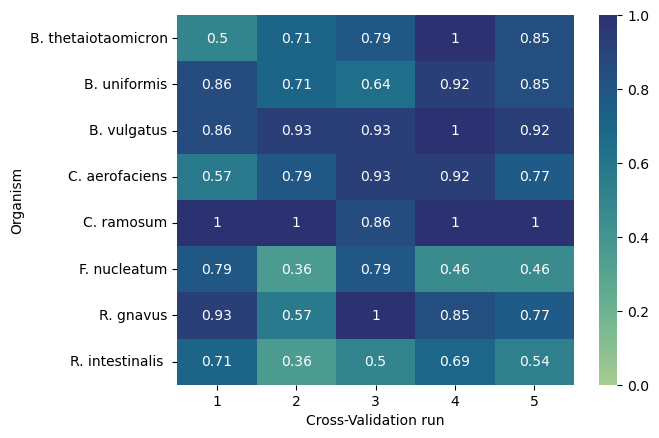

In [ ]:
# Accuracy CV matrix
ax = sns.heatmap(metrics_df.pivot(index="Organism", columns="Cross-Validation run", values="Accuracy"),
                 vmin=0, vmax=1.0, annot=True, cmap=sns.color_palette("crest", as_cmap=True))

In [ ]:
plot_cv_confmat(ys=ys, target_labels=strains.values, accuracies=np.mean(accuracies, axis=1), confusion_matrices=confusion_matrices,
				outdir="../../runs/ML/try/NN", name="class_annot_test_1.png")